In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
import shutil
import os
import zipfile

Zip_dir = '/content'
Data_dir = '/content/bird-groups'

if os.path.exists(Data_dir):
  shutil.rmtree(Data_dir)

with zipfile.ZipFile(os.path.join('/content/drive/MyDrive/data','bird.zip'),'r') as file:
  file.extractall(Zip_dir)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import glob
import pandas as pd

def img_load(img):
  img=cv2.imread(img,cv2.IMREAD_COLOR)
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  img=cv2.resize(img,img_size)
  return img

img_size = (224,224)

img_gen = ImageDataGenerator(rotation_range=20.0,rescale=1/255,
                              zoom_range=0.2,horizontal_flip=True)

df_gen = ImageDataGenerator(rescale=1/255)

dir = os.listdir(Data_dir)

data = []

for l in dir:
  path = os.path.join(Data_dir,l)
  for f in glob.glob(path + '/*.jpg'):
    fl = []
    fl.append(f)
    fl.append(l)
    data.append(fl)

#data_dict = {file_path : f_path, label : label}
df = pd.DataFrame(data=data,columns=['file_path','label'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

Label = LabelEncoder()

df_train , df_test = train_test_split(df, test_size=0.3,random_state=37, stratify = df['label'])

df_test , df_val = train_test_split(df_test,test_size=0.5,random_state=37, stratify = df_test['label'])

count = df_train.groupby('label')['label'].count()
print(count)
print(max(count))


label
Order Anseriformes           67
Order Apodiformes            64
Order Apterygiformes         57
Order Caprimulgiformes       66
Order Casuariiformes         57
Order Charadriiformes        69
Order Ciconiiformes          69
Order Coliiformes            66
Order Columbiformes          66
Order Coraciiformes          67
Order Cuculiformes           65
Order Falconiformes          69
Order Galliformes            69
Order Gaviiformes            66
Order Gruiformes             67
Order Passeriformes          67
Order Pelecaniformes         63
Order Phoenicopteriformes    65
Order Piciformes             65
Order Podicipediformes       62
Order Procellariiformes      62
Order Psittaciformes         68
Order Pteroclidiformes       55
Order Rheiformes             64
Order Sphenisciformes        63
Order Strigiformes           59
Order Struthioniformes       67
Order Tinamiformes           64
Order Trogoniformes          65
Order Turniciformes          68
Name: label, dtype: int64
69


In [ ]:
aug_dir = '/content/aug'

if os.path.exists(aug_dir):
  shutil.rmtree(aug_dir)

os.mkdir(aug_dir)

copy_size = 150

train_img=[]
train_label=[]

for l in count.index:
  group = df_train.groupby('label')
  df_label = group.get_group(l)
  c = count[l]
  os.mkdir(os.path.join(aug_dir,l))
  gen_img = img_gen.flow_from_dataframe(df_label,x_col='file_path',y_col='label',target_size=img_size,
                                        class_mode=None,batch_size=1,color_mode='rgb')
  df_img = df_gen.flow_from_dataframe(df_label,x_col='file_path',y_col='label',target_size=img_size,
                                           class_mode=None,batch_size=1,color_mode='rgb')

  for j in range(c):
    img = df_img.next()
    train_img.append(img)
    train_label.append(l)

  for i in range(copy_size - c):
    img = gen_img.next()
    train_img.append(img)
    train_label.append(l)
  
  print(copy_size-c,l)

train_img,train_label = shuffle(train_img,train_label)

train_img = tf.reshape(train_img,[-1,224,224,3])
train_label = Label.fit_transform(train_label)
train_label = tf.reshape(train_label,[-1,1])

df_test = df_gen.flow_from_dataframe(df_test,x_col='file_path',y_col='label',target_size=img_size,
                                     class_mode='sparse',batch_size=32,color_mode='rgb')
df_val = df_gen.flow_from_dataframe(df_val,x_col='file_path',y_col='label',target_size=img_size,
                                    class_mode='sparse',batch_size=32,color_mode='rgb')

Found 67 validated image filenames.
Found 67 validated image filenames.
83 Order Anseriformes
Found 64 validated image filenames.
Found 64 validated image filenames.
86 Order Apodiformes
Found 57 validated image filenames.
Found 57 validated image filenames.
93 Order Apterygiformes
Found 66 validated image filenames.
Found 66 validated image filenames.
84 Order Caprimulgiformes
Found 57 validated image filenames.
Found 57 validated image filenames.
93 Order Casuariiformes
Found 69 validated image filenames.
Found 69 validated image filenames.
81 Order Charadriiformes
Found 69 validated image filenames.
Found 69 validated image filenames.
81 Order Ciconiiformes
Found 66 validated image filenames.
Found 66 validated image filenames.
84 Order Coliiformes
Found 66 validated image filenames.
Found 66 validated image filenames.
84 Order Columbiformes
Found 67 validated image filenames.
Found 67 validated image filenames.
83 Order Coraciiformes
Found 65 validated image filenames.
Found 65 val

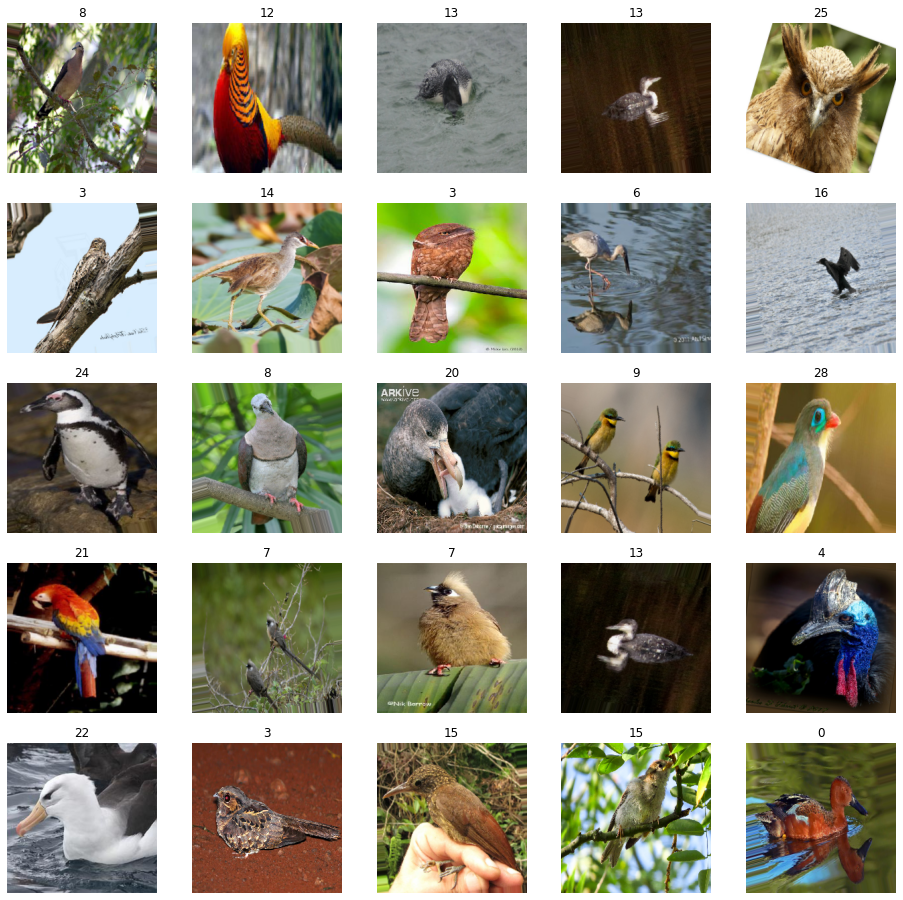

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.figure(figsize=(16,16))

for i in range(25):
  plt.subplot(5,5,i+1)
  img = np.array(train_img[i])
  plt.imshow(img)
  plt.title(np.array(train_label[i])[0])
  plt.axis('off')

plt.show()

In [ ]:
#!pip install scikeras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Activation , Conv2D , MaxPooling2D , GlobalMaxPooling2D , Flatten
from tensorflow.keras.applications import Xception , MobileNet , EfficientNetB3
from tensorflow.keras import regularizers
#from scikeras.wrappers import KerasClassifier

base_model = Xception(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='max')

model = Sequential([
                    base_model,
                    Dense(1024,kernel_regularizer=regularizers.L2(1e-5),bias_regularizer=regularizers.L2(1e-5)),
                    BatchNormalization(),Activation('relu'),Dropout(0.4),
                    Dense(512,kernel_regularizer=regularizers.L2(1e-5),bias_regularizer=regularizers.L2(1e-5)),
                    BatchNormalization(),Activation('relu'),Dropout(0.4),
                    Dense(256,kernel_regularizer=regularizers.L2(1e-5)),
                    BatchNormalization(),Activation('relu'),Dropout(0.4),
                    Dense(len(Label.classes_),activation='softmax')
                    ])

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               52

In [ ]:
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint , EarlyStopping
cp_path='/contents/checkpoint'

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=0.2,patience=5)
model_cp = ModelCheckpoint(cp_path,monitor='val_loss',save_best_only=True,save_weights_only=True)
early_st = EarlyStopping(monitor='val_loss',patience=5)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

hist = model.fit(train_img,train_label,epochs = 40,validation_data=df_val,callbacks=[reduce_lr,model_cp,early_st])

In [ ]:
model.load_weights(cp_path)

model.evaluate(df_test)

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()